In [90]:
import os
import numpy as np
import pandas as pd
#import xgboost as xgb
import matplotlib.pyplot as plt
#from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from contextualized.easy import ContextualizedRegressor

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [91]:

file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_with_context_f.csv' # cleaned data
df = pd.read_csv(file_path)
df = df.dropna(subset=['relative_quarterly_return'])

df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 11723 entries, 1 to 11812
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tic                             11723 non-null  object 
 1   datadate                        11723 non-null  object 
 2   roa                             11692 non-null  float64
 3   roe                             11563 non-null  float64
 4   pe_inc                          11199 non-null  float64
 5   divyield                        9443 non-null   float64
 6   pcf                             11692 non-null  float64
 7   roce                            11586 non-null  float64
 8   gpm                             11711 non-null  float64
 9   evm                             11636 non-null  float64
 10  npm                             11712 non-null  float64
 11  PEG_trailing                    8110 non-null   float64
 12  de_ratio                        11708

,tic,datadate,roa,roe,pe_inc,divyield,pcf,roce,gpm,evm,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
11808,ZTS,2018-12-31,0.230,0.594,32.160,0.696,25.204,0.250,0.708,21.308,...,3.2636,4.3514,1.33,-0.101,-7.090,3.183,-4.273,-0.413,-0.531,0.227
11809,ZTS,2019-03-31,0.239,0.577,35.332,0.649,27.021,0.252,0.715,21.631,...,-3.5981,-5.1201,1.24,-0.079,-2.895,3.745,-2.919,-0.446,-0.452,0.308
11810,ZTS,2019-06-30,0.233,0.539,44.671,0.519,32.794,0.241,0.722,22.510,...,2.6492,1.1047,1.21,-0.115,-7.734,3.796,-3.920,-0.411,-0.512,0.251
11811,ZTS,2019-09-30,0.228,0.538,39.907,0.544,31.944,0.234,0.728,23.287,...,3.8375,0.8189,1.22,-0.092,-6.526,3.278,-3.883,-0.416,-0.509,0.258
11812,ZTS,2019-12-31,0.226,0.517,42.839,0.600,35.251,0.235,0.736,27.557,...,-1.9816,0.6485,1.10,-0.088,-8.014,3.910,-3.433,-0.447,-0.545,0.285


In [92]:
print(df.columns.tolist())
print(df.notna().sum().sort_values())



['tic', 'datadate', 'roa', 'roe', 'pe_inc', 'divyield', 'pcf', 'roce', 'gpm', 'evm', 'npm', 'PEG_trailing', 'de_ratio', 'ptb', 'market_cap', 'prccq_change', 'capxy_change', 'oancfy_change', 'actq_change', 'lctq_change', 'roa_change', 'roe_change', 'pe_inc_change', 'divyield_change', 'pcf_change', 'roce_change', 'gpm_change', 'evm_change', 'npm_change', 'PEG_trailing_change', 'de_ratio_change', 'ptb_change', 'next_prccq_change', 'relative_quarterly_return', 'next_relative_quarterly_return', 'volatility_score', 'FFI10_desc', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'divyield_Median', 'PEG_trailing_Median', 'pe_inc_Median', 'ptb_Median', 'evm_Median', 'roce_Median', 'roe_Median', 'bm_Median']
PEG_trailing_change     7371
PEG_trailing            8110
oancfy_change           8131
capxy_change            8602
lctq_change             9189
                       ...  
roe_Median   

In [93]:


df = df.loc[:, df.count() >= 11000]

# Drop rows with missing values
df = df.dropna()

# Display dataframe info
df.info()

print(df.columns.tolist())


<class 'pandas.core.frame.DataFrame'>
Index: 10509 entries, 2 to 11812
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tic                             10509 non-null  object 
 1   datadate                        10509 non-null  object 
 2   roa                             10509 non-null  float64
 3   roe                             10509 non-null  float64
 4   pe_inc                          10509 non-null  float64
 5   pcf                             10509 non-null  float64
 6   roce                            10509 non-null  float64
 7   gpm                             10509 non-null  float64
 8   evm                             10509 non-null  float64
 9   npm                             10509 non-null  float64
 10  de_ratio                        10509 non-null  float64
 11  ptb                             10509 non-null  float64
 12  market_cap                      10509

In [94]:
# Find the unique number of stocks in the dataframe
unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")
print(unique_gvkeys)


Number of unique gvkeys: 76
['AAPL' 'ABT' 'ADM' 'AFL' 'AIG' 'AMD' 'AMT' 'AMZN' 'APD' 'BA' 'BAX' 'BMY'
 'BRK.B' 'CAT' 'CL' 'CME' 'COP' 'CTSH' 'CVS' 'CVX' 'DIS' 'ECL' 'EQIX'
 'EXC' 'EXPE' 'F' 'FIS' 'GE' 'GOOGL' 'GS' 'HCA' 'IBM' 'INTC' 'JNJ' 'JPM'
 'KMB' 'KO' 'LLY' 'LMT' 'LUV' 'MA' 'MCD' 'META' 'MMC' 'MMM' 'MRK' 'MS'
 'MSFT' 'NFLX' 'NOC' 'OXY' 'PFE' 'PG' 'PGR' 'PPL' 'PYPL' 'QCOM' 'REGN'
 'RJF' 'RTX' 'SBUX' 'SCHW' 'SPGI' 'T' 'TMO' 'TSLA' 'TSN' 'UNH' 'UPS' 'V'
 'VZ' 'WBA' 'WDC' 'WFC' 'XOM' 'ZTS']


In [95]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")

df.tail()

Number of unique gvkeys: 76


,tic,datadate,roa,roe,pe_inc,pcf,roce,gpm,evm,npm,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
876,AIG,2019-12-31,0.023,0.054,11.273,-37.158,0.066,0.236,7.292,0.067,...,-1.9816,0.6485,2.2,0.616,13.611,1.387,10.016,0.102,0.097,0.770
5972,JPM,2019-12-31,0.027,0.153,10.831,59.034,0.083,0.773,13.715,0.256,...,-1.9816,0.6485,2.2,0.616,13.611,1.387,10.016,0.102,0.097,0.770
5772,JNJ,2019-12-31,0.181,0.228,23.886,15.131,0.237,0.751,14.671,0.184,...,-1.9816,0.6485,1.1,-0.088,-8.014,3.910,-3.433,-0.447,-0.545,0.285
1932,BAX,2019-12-31,0.161,0.125,43.249,20.255,0.154,0.502,17.713,0.088,...,-1.9816,0.6485,2.2,0.616,13.611,1.387,10.016,0.102,0.097,0.770
11812,ZTS,2019-12-31,0.226,0.517,42.839,35.251,0.235,0.736,27.557,0.239,...,-1.9816,0.6485,1.1,-0.088,-8.014,3.910,-3.433,-0.447,-0.545,0.285


In [96]:
tickers_to_drop = ['AMT', 'CTSH', 'GOOGL', 'META', 'PYPL', 'RJF', 'TSLA', 'ZTS']

#df = df[~df['tic'].isin(tickers_to_drop)]

In [97]:
train_start_date = '1900-03-31'
valid_start_date = '2008-03-31'
test_start_date = '2013-03-31'
end_date = '2026-09-30'

df = df.sort_values(by=['datadate'])

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)]

test_df = test_df.sort_values(by=['datadate', 'next_prccq_change'], ascending=[True, False])
test_df.tail()


,tic,datadate,roa,roe,pe_inc,pcf,roce,gpm,evm,npm,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
4330,EXPE,2019-12-31,0.095,0.138,26.159,4.793,0.111,0.828,11.237,0.047,...,-1.9816,0.6485,1.37,0.306,1.471,3.459,12.578,0.043,0.004,0.289
4530,F,2019-12-31,0.060,0.001,306.600,1.537,0.030,0.180,12.526,0.000,...,-1.9816,0.6485,2.31,0.416,11.098,2.718,9.116,0.098,0.085,0.413
2953,COP,2019-12-31,0.190,0.188,7.566,4.714,0.130,0.444,6.459,0.221,...,-1.9816,0.6485,2.55,0.090,3.964,0.919,5.440,0.061,0.047,1.103
876,AIG,2019-12-31,0.023,0.054,11.273,-37.158,0.066,0.236,7.292,0.067,...,-1.9816,0.6485,2.20,0.616,13.611,1.387,10.016,0.102,0.097,0.770
8520,OXY,2019-12-31,0.129,-0.023,-26.836,3.974,0.081,0.540,8.755,-0.032,...,-1.9816,0.6485,2.55,0.090,3.964,0.919,5.440,0.061,0.047,1.103


In [98]:
# Create a copy of the test results
results = test_df[['datadate', 'tic', 'next_prccq_change', 'next_relative_quarterly_return']].copy()

# Define columns to drop
drop_cols = ['datadate', 'tic', 'next_prccq_change', 'FFI10_desc']

# Drop the specified columns from train, validation, and test datasets
train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

# Display the first few rows of the training dataset
train_df.head()


,roa,roe,pe_inc,pcf,roce,gpm,evm,npm,de_ratio,ptb,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
1335,0.145,0.093,17.928,8.009,0.117,0.507,7.570,0.057,1.440,1.387,...,-6.2954,-10.1619,3.51,0.908,14.712,1.435,9.151,0.102,0.087,0.612
3443,0.204,0.115,41.576,41.821,0.209,0.309,13.130,0.130,0.227,3.479,...,-6.2954,-10.1619,2.95,0.855,12.418,1.368,7.375,0.187,0.106,0.655
11213,0.112,0.094,14.020,16.465,0.122,0.276,7.442,0.013,1.215,1.280,...,-6.2954,-10.1619,3.70,1.084,12.710,1.218,7.059,0.166,0.091,0.689
7019,0.248,0.441,30.332,25.417,0.283,0.386,16.650,0.091,1.872,9.436,...,-6.2954,-10.1619,2.95,0.855,12.418,1.368,7.375,0.187,0.106,0.655
3444,0.204,0.105,47.375,56.869,0.209,0.309,13.130,0.135,0.227,4.730,...,5.6547,6.2280,2.71,1.046,13.920,1.415,7.319,0.183,0.115,0.673


In [99]:
# Define target variable (y) and features (X) for train, validation, and test sets
y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(columns=['next_relative_quarterly_return'])

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(columns=['next_relative_quarterly_return'])

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(columns=['next_relative_quarterly_return'])

# Display the first few rows of X_train
X_train.head()


,roa,roe,pe_inc,pcf,roce,gpm,evm,npm,de_ratio,ptb,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
1335,0.145,0.093,17.928,8.009,0.117,0.507,7.570,0.057,1.440,1.387,...,-6.2954,-10.1619,3.51,0.908,14.712,1.435,9.151,0.102,0.087,0.612
3443,0.204,0.115,41.576,41.821,0.209,0.309,13.130,0.130,0.227,3.479,...,-6.2954,-10.1619,2.95,0.855,12.418,1.368,7.375,0.187,0.106,0.655
11213,0.112,0.094,14.020,16.465,0.122,0.276,7.442,0.013,1.215,1.280,...,-6.2954,-10.1619,3.70,1.084,12.710,1.218,7.059,0.166,0.091,0.689
7019,0.248,0.441,30.332,25.417,0.283,0.386,16.650,0.091,1.872,9.436,...,-6.2954,-10.1619,2.95,0.855,12.418,1.368,7.375,0.187,0.106,0.655
3444,0.204,0.105,47.375,56.869,0.209,0.309,13.130,0.135,0.227,4.730,...,5.6547,6.2280,2.71,1.046,13.920,1.415,7.319,0.183,0.115,0.673


In [100]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#X_train_scaled.info()

print(X_train_scaled.columns.tolist())


['roa', 'roe', 'pe_inc', 'pcf', 'roce', 'gpm', 'evm', 'npm', 'de_ratio', 'ptb', 'market_cap', 'prccq_change', 'roa_change', 'roe_change', 'pe_inc_change', 'pcf_change', 'roce_change', 'gpm_change', 'evm_change', 'npm_change', 'de_ratio_change', 'ptb_change', 'relative_quarterly_return', 'volatility_score', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'divyield_Median', 'PEG_trailing_Median', 'pe_inc_Median', 'ptb_Median', 'evm_Median', 'roce_Median', 'roe_Median', 'bm_Median']


In [101]:
X_train_valid = np.vstack([X_train_scaled, X_valid_scaled])
y_train_valid = np.hstack([y_train, y_valid])


In [102]:
# Define the Ridge model
ridge_model = Ridge()

# Define the parameter grid for alpha values
param_grid = {'alpha': [0.0, 1, 5, 10.0, 100.0, 1000, 2000, 5000, 10000]}

# Perform GridSearchCV to find the best alpha
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")
# Train the Ridge model with the best alpha
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_valid, y_train_valid)

Best alpha: 1


Ridge(alpha=10)

In [103]:

#context = ['relative_quarterly_return_-1', 'relative_quarterly_return_-2', 'relative_quarterly_return_-3', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'indret_ew', 'CAPEI_Median', 'bm_Median', 'evm_Median', 'pe_inc_Median', 'ptb_Median', 'PEG_trailing_Median', 'divyield_Median', 'roa_Median', 'roce_Median', 'roe_Median', 'gpm_Median', 'npm_Median', 'opmad_Median', 'de_ratio_Median', 'debt_ebitda_Median', 'debt_assets_Median', 'intcov_ratio_Median', 'cash_ratio_Median', 'curr_ratio_Median', 'quick_ratio_Median', 'at_turn_Median', 'inv_turn_Median', 'rect_turn_Median']
context = ['market_cap', 'volatility_score', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'divyield_Median', 'PEG_trailing_Median', 'pe_inc_Median', 'ptb_Median', 'evm_Median', 'roce_Median', 'roe_Median', 'bm_Median']


C_train = X_train_scaled[context].to_numpy()
C_valid = X_valid_scaled[context].to_numpy()
C_test = X_test_scaled[context].to_numpy()

X_train_context = X_train_scaled.drop(columns=context)
X_valid_context = X_valid_scaled.drop(columns=context)
X_test_context = X_test_scaled.drop(columns=context)

X_train_valid_c = np.vstack([X_train_context, X_valid_context])

In [104]:
# Define the Ridge model
agnostic_model = Ridge()

# Define the parameter grid for alpha values
param_grid = {'alpha': [0.0, 1, 5, 10.0, 100.0, 1000, 2000, 5000, 10000]}

# Perform GridSearchCV to find the best alpha
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Train the Ridge model with the best alpha
agnostic_model = Ridge(alpha=100)
agnostic_model.fit(X_train_valid_c, y_train_valid)

Best alpha: 1


Ridge(alpha=100)

In [105]:
'''contextualised_model = ContextualizedRegressor()
contextualised_model.fit(C_train, X_train_context.to_numpy(), y_train.to_numpy())'''


'contextualised_model = ContextualizedRegressor()\ncontextualised_model.fit(C_train, X_train_context.to_numpy(), y_train.to_numpy())'

In [106]:
from contextualized.utils import save, load

contextualised_model = load('/Users/edocampione/Desktop/Meng Engineering Science/4YP/models/thecontextualized_model_1.pt' )

#save(contextualised_model, path='thecontextualized_model_1.pt')

In [107]:
y_train_pred3 = agnostic_model.predict(X_train_context.to_numpy())
y_valid_pred3 = agnostic_model.predict(X_valid_context.to_numpy())
y_test_pred3 = agnostic_model.predict(X_test_context.to_numpy())

# Classifier
y_train_pred_binary3 = (y_train_pred3 >= 0).astype(int)
y_valid_pred_binary3 = (y_valid_pred3 >= 0).astype(int)
y_test_pred_binary3 = (y_test_pred3 >= 0).astype(int)

y_train_binary3 = (y_train >= 0).astype(int)
y_valid_binary3 = (y_valid >= 0).astype(int)
y_test_binary3 = (y_test >= 0).astype(int)

print(y_test_pred3)

print(classification_report(y_test_binary3, y_test_pred_binary3))

[0.03953268 0.02936699 0.02906636 ... 0.01686923 0.01552978 0.01780339]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       954
           1       0.51      1.00      0.67       986

    accuracy                           0.51      1940
   macro avg       0.25      0.50      0.34      1940
weighted avg       0.26      0.51      0.34      1940



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [108]:
y_train_pred1 = ridge_model.predict(X_train_scaled)
y_valid_pred1 = ridge_model.predict(X_valid_scaled)
y_test_pred1 = ridge_model.predict(X_test_scaled)

# Classifier
y_train_pred_binary1 = (y_train_pred1 >= 0).astype(int)
y_valid_pred_binary1 = (y_valid_pred1 >= 0).astype(int)
y_test_pred_binary1 = (y_test_pred1 >= 0).astype(int)

y_train_binary1 = (y_train >= 0).astype(int)
y_valid_binary1 = (y_valid >= 0).astype(int)
y_test_binary1 = (y_test >= 0).astype(int)

print(y_test_pred1)

print(classification_report(y_test_binary1, y_test_pred_binary1))



[ 0.08587085  0.07925118  0.07679392 ... -0.00610488 -0.02011233
  0.00133202]
              precision    recall  f1-score   support

           0       0.60      0.53      0.56       954
           1       0.59      0.66      0.62       986

    accuracy                           0.59      1940
   macro avg       0.60      0.59      0.59      1940
weighted avg       0.60      0.59      0.59      1940



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but Ridge was fitted without feature names

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but Ridge was fitted without feature names

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but Ridge was fitted without feature names



In [109]:
y_train_pred2 = contextualised_model.predict(C_train, X_train_context.to_numpy())
y_valid_pred2 = contextualised_model.predict(C_valid, X_valid_context.to_numpy())
y_test_pred2 = contextualised_model.predict(C_test, X_test_context.to_numpy())

# Classifier
y_train_pred_binary2 = (y_train_pred2 >= 0).astype(int)
y_valid_pred_binary2 = (y_valid_pred2 >= 0).astype(int)
y_test_pred_binary2 = (y_test_pred2 >= 0).astype(int)

y_train_binary2 = (y_train >= 0).astype(int)
y_valid_binary2 = (y_valid >= 0).astype(int)
y_test_binary2 = (y_test >= 0).astype(int)

print(y_test_pred2)

print(classification_report(y_test_binary2, y_test_pred_binary2))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



[[ 0.16985063]
 [ 0.16973175]
 [ 0.05471596]
 ...
 [-0.06892331]
 [-0.07395104]
 [-0.06610771]]
              precision    recall  f1-score   support

           0       0.53      0.88      0.66       954
           1       0.68      0.25      0.36       986

    accuracy                           0.56      1940
   macro avg       0.61      0.56      0.51      1940
weighted avg       0.61      0.56      0.51      1940



In [110]:
mse = mean_squared_error(y_test, y_test_pred3)
mae = mean_absolute_error(y_test, y_test_pred3)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

mse = mean_squared_error(y_test, y_test_pred1)
mae = mean_absolute_error(y_test, y_test_pred1)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

mse = mean_squared_error(y_test, y_test_pred2)
mae = mean_absolute_error(y_test, y_test_pred2)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 0.0147, MAE: 0.0830
MSE: 0.0140, MAE: 0.0805
MSE: 0.0165, MAE: 0.0838


In [111]:
results['y_pred1'] = y_test_pred1
results['y_pred2'] = y_test_pred2
results['y_pred3'] = y_test_pred3
results1 = results.sort_values(by=['datadate'], ascending=[True])

results1.head(60)



,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred1,y_pred2,y_pred3
10615,2013-03-31,TSLA,1.833465,1.799673,0.085871,0.169851,0.039533
7189,2013-03-31,MCD,-0.006921,-0.040714,0.004037,-0.031307,0.020144
9827,2013-03-31,RTX,-0.005245,-0.039037,0.006786,-0.028783,0.020174
3413,2013-03-31,CVX,-0.004040,-0.037832,0.004031,-0.038338,0.018595
8893,2013-03-31,PG,-0.000908,-0.034701,-0.002974,-0.042030,0.019373
4303,2013-03-31,EXPE,0.002249,-0.031543,0.018477,-0.052134,0.018686
11756,2013-03-31,XOM,0.002663,-0.031129,0.001381,-0.044190,0.018595
6145,2013-03-31,KMB,-0.008573,-0.042366,0.019894,-0.003685,0.022178
4759,2013-03-31,GE,0.003028,-0.030765,-0.017536,-0.055266,0.019663
9033,2013-03-31,PGR,0.005936,-0.027857,0.007014,-0.039407,0.019532


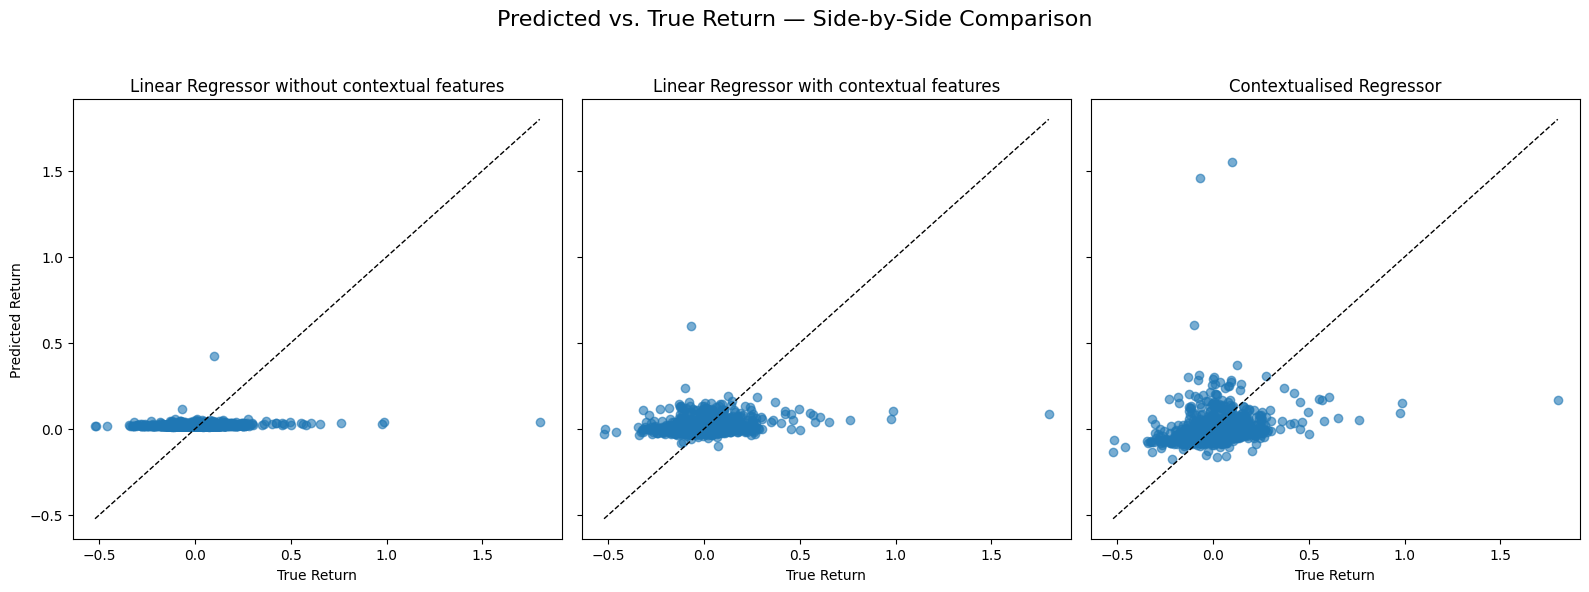

In [112]:
# Example: comparing two models (or just showing the same model twice)
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

# Define line range (diagonal for perfect prediction)
min_val = min(y_test.min(), y_test_pred1.min(), y_test_pred2.min(), y_test_pred3.min())
max_val = max(y_test.max(), y_test_pred1.max(), y_test_pred2.max(), y_test_pred3.max())

# First plot (linear model)
axs[0].scatter(y_test, y_test_pred3, alpha=0.6)
axs[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)  # perfect line
axs[0].set_title("Linear Regressor without contextual features")
axs[0].set_xlabel("True Return")
axs[0].set_ylabel("Predicted Return")

# Second plot (linear model with context)
axs[1].scatter(y_test, y_test_pred1, alpha=0.6)
axs[1].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)
axs[1].set_title("Linear Regressor with contextual features")
axs[1].set_xlabel("True Return")
axs[1].set_ylabel("")

# Third plot (Contextualised Regressor)
axs[2].scatter(y_test, y_test_pred2, alpha=0.6)
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)
axs[2].set_title("Contextualised Regressor")
axs[2].set_xlabel("True Return")
axs[2].set_ylabel("")

plt.suptitle("Predicted vs. True Return — Side-by-Side Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [113]:
def softmax_weighted_return(df, sort_col, target_col, n=5, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=3, largest=True, alpha=0):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()


# Baseline aggregation remains unchanged.
df_avg = results.groupby('datadate').agg(
    stocks=('next_prccq_change', 'size'),
    baseline=('next_prccq_change', 'mean')
).reset_index()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred1',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10_agnostic'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred3',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10_context'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred2',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the ideal top 10, weight by the actual returns
df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_prccq_change',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred1',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10_agnostic'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred3',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10_context'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred2',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the ideal bottom 10, weight by the actual returns
df_avg['bottom_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_prccq_change',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(100)


,datadate,stocks,baseline,top_10,top_10_agnostic,top_10_context,top_10_ideal,bottom_10,bottom_10_agnostic,bottom_10_context,bottom_10_ideal
0,2013-03-31,70,0.077383,0.852390,0.642647,0.852390,0.902758,-0.044972,-0.058125,-0.069631,-0.154523
1,2013-06-30,69,0.081841,0.553242,0.337410,0.409995,0.761617,-0.000101,-0.009615,-0.076432,-0.092545
2,2013-09-30,70,0.105676,0.044706,0.081390,0.219497,0.320609,0.029279,0.012048,-0.024048,-0.142566
3,2013-12-31,70,0.030107,0.148058,0.061776,0.148058,0.318063,0.025265,-0.001594,0.026288,-0.127698
4,2014-03-31,70,0.031233,0.151422,0.151422,0.048126,0.227395,-0.178768,-0.168130,-0.189999,-0.238462
5,2014-06-30,72,0.021678,0.103746,-0.002829,0.009241,0.236063,-0.055447,0.012824,-0.036036,-0.145233
6,2014-09-30,71,0.041867,-0.088502,-0.088502,0.047297,0.230704,-0.018404,-0.158707,-0.120114,-0.207161
7,2014-12-31,70,0.013406,0.006273,-0.012968,-0.065740,0.201174,-0.050204,-0.007087,0.020913,-0.155817
8,2015-03-31,71,0.018974,-0.057266,-0.057266,0.101991,0.388086,-0.028251,0.054344,-0.069512,-0.171955
9,2015-06-30,71,-0.057272,-0.028492,-0.028492,-0.028492,0.170299,-0.239976,-0.235687,-0.317484,-0.347668


In [114]:

risk_free_rate = 0.02  # 2% annual risk-free rate, approximated quarterly

for portfolio in ['baseline', 'top_10_agnostic', 'top_10', 'top_10_context', 'top_10_ideal']:
    
    returns = df_avg[portfolio]
    mean_return = returns.mean()
    
    # Calculate downside deviation: only consider returns below the risk-free rate
    downside_returns = returns[returns < risk_free_rate]
    downside_deviation = np.std(downside_returns) if len(downside_returns) > 0 else 0
    
    # Compute excess return
    excess_return = mean_return - risk_free_rate
    
    # Avoid division by zero
    sortino_ratio = excess_return / downside_deviation if downside_deviation > 0 else np.nan
    
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return:.4f}")
    #print(f"Downside deviation of the {portfolio} portfolio: {downside_deviation:.4f}")
    print(f"Sortino Ratio of the {portfolio} portfolio: {sortino_ratio:.4f}")
    print("")


for portfolio in ['bottom_10_agnostic', 'bottom_10', 'bottom_10_context', 'bottom_10_ideal']:
    
    returns = df_avg[portfolio]
    mean_return = returns.mean()
    
    # Calculate downside deviation: only consider returns below the risk-free rate
    downside_returns = returns[returns > -1 * risk_free_rate]
    downside_deviation = np.std(downside_returns) if len(downside_returns) > 0 else 0
    
    # Compute excess return
    excess_return = np.abs(mean_return) - risk_free_rate
    
    # Avoid division by zero
    sortino_ratio = excess_return / downside_deviation if downside_deviation > 0 else np.nan
    
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return:.4f}")
    #print(f"Downside deviation of the {portfolio} portfolio: {downside_deviation:.4f}")
    print(f"Sortino Ratio of the {portfolio} portfolio: {sortino_ratio:.4f}")
    print("")

Mean quarterly return of the baseline portfolio: 0.0284
Sortino Ratio of the baseline portfolio: 0.1127

Mean quarterly return of the top_10_agnostic portfolio: 0.0933
Sortino Ratio of the top_10_agnostic portfolio: 2.5730

Mean quarterly return of the top_10 portfolio: 0.1167
Sortino Ratio of the top_10 portfolio: 2.7947

Mean quarterly return of the top_10_context portfolio: 0.1220
Sortino Ratio of the top_10_context portfolio: 3.6066

Mean quarterly return of the top_10_ideal portfolio: 0.3288
Sortino Ratio of the top_10_ideal portfolio: nan

Mean quarterly return of the bottom_10_agnostic portfolio: -0.0534
Sortino Ratio of the bottom_10_agnostic portfolio: 0.8013

Mean quarterly return of the bottom_10 portfolio: -0.0360
Sortino Ratio of the bottom_10 portfolio: 0.4262

Mean quarterly return of the bottom_10_context portfolio: -0.0816
Sortino Ratio of the bottom_10_context portfolio: 3.3712

Mean quarterly return of the bottom_10_ideal portfolio: -0.1918
Sortino Ratio of the botto

In [115]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Create initial row
initial_row = {
    'datadate': pd.to_datetime('2012-12-31'),
    'baseline': 0,
    'top_10_agnostic': 0,
    'top_10': 0,
    'top_10_context': 0,
    'top_10_ideal': 0,
}

# Convert to DataFrame and concatenate
initial_df = pd.DataFrame([initial_row])
df_avg = pd.concat([initial_df, df_avg], ignore_index=True)

# Recalculate cumulative returns from scratch
for col in ['baseline', 'top_10_agnostic', 'top_10', 'top_10_context', 'top_10_ideal']:
    df_avg[f'{col}_cum_return'] = (1 + df_avg[col]).cumprod()
    df_avg[f'{col}_value'] = 1000 * df_avg[f'{col}_cum_return']


# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_10_a_cum_return'] = (1 + df_avg['top_10_agnostic']).cumprod()
df_avg['top_10_cum_return'] = (1 + df_avg['top_10']).cumprod()
df_avg['top_10_context_cum_return'] = (1 + df_avg['top_10_context']).cumprod()
df_avg['top_10_ideal_cum_return'] = (1 + df_avg['top_10_ideal']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_10_a_value'] = initial_investment * df_avg['top_10_a_cum_return']
df_avg['top_10_value'] = initial_investment * df_avg['top_10_cum_return']
df_avg['top_10_context_value'] = initial_investment * df_avg['top_10_context_cum_return']
df_avg['top_10_ideal_value'] = initial_investment * df_avg['top_10_ideal_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Universe'))

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_a_value'],
                         mode='lines', name='Context-agnostic'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_value'],
                         mode='lines', name='Context-aware'))

fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_context_value'],
                         mode='lines', name='ContextualisedML'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
    width=700,   # make the plot narrower
    height=500   # optionally make it taller

)

# Show the plot
fig.show()


In [116]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Create initial row
initial_row = {
    'datadate': pd.to_datetime('2012-12-31'),
    'baseline': 0,
    'bottom_10_agnostic': 0,
    'bottom_10': 0,
    'bottom_10_context': 0,
    'bottom_10_ideal': 0,
}

# Convert to DataFrame and concatenate
initial_df = pd.DataFrame([initial_row])
df_avg = pd.concat([initial_df, df_avg], ignore_index=True)

# Recalculate cumulative returns from scratch
for col in ['baseline', 'bottom_10_agnostic', 'bottom_10', 'bottom_10_context', 'bottom_10_ideal']:
    df_avg[f'{col}_cum_return'] = (1 + df_avg[col]).cumprod()
    df_avg[f'{col}_value'] = 1000 * df_avg[f'{col}_cum_return']


# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['bottom_10_a_cum_return'] = (1 + df_avg['bottom_10_agnostic']).cumprod()
df_avg['bottom_10_cum_return'] = (1 + df_avg['bottom_10']).cumprod()
df_avg['bottom_10_context_cum_return'] = (1 + df_avg['bottom_10_context']).cumprod()
df_avg['bottom_10_ideal_cum_return'] = (1 + df_avg['bottom_10_ideal']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['bottom_10_a_value'] = initial_investment * df_avg['bottom_10_a_cum_return']
df_avg['bottom_10_value'] = initial_investment * df_avg['bottom_10_cum_return']
df_avg['bottom_10_context_value'] = initial_investment * df_avg['bottom_10_context_cum_return']
df_avg['bottom_10_ideal_value'] = initial_investment * df_avg['bottom_10_ideal_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Universe'))

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['bottom_10_a_value'],
                         mode='lines', name='Context-agnostic'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['bottom_10_value'],
                         mode='lines', name='Context-aware'))

fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['bottom_10_context_value'],
                         mode='lines', name='ContextualisedML'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
    width=700,   # make the plot narrower
    height=500   # optionally make it taller

)

# Show the plot
fig.show()
